# Tool Evaluation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from itertools import product
import seaborn as sns




In [2]:
plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
# sns.set(rc={'figure.figsize':(10,4)})


In [28]:
EXPERIMENT_DESCRIPTORS = ['dataset_type', 'dataset', 'model']

DATASET_ESTIMATORS = [
    'model_type', # SimpleCNN, RESNET, ...
    'data_type', # Spectogram, SensorData, ...
    'n_parameters',
    'datapoint_w', 
    'datapoint_h', 
    'dimensions', 
    'num_classes', 
    'original_data_size'
]

RUN_DESCRIPTORS = [
    'iteration',
    'data_quality_dimension_percentage',
    'loss',
    'categorical_accuracy',
    'categorical_crossentropy',
    'top_3_accuracy',
    'top_5_accuracy',
    'precision',
    'recall',
    'auc',
    'f1_score',
    'effective_epochs',
    'used_data_size',
    'actual_data_percentage_used',
    'emissions_kg',
    'duration',
]


DATASET_TYPE_NAMES = ['images', 'time_series']
DATASET_NAMES = []
MODEL_NAMES = []

MODEL_TYPES = ['SIMPLE_CNN', 'SIMPLE_MLP', 'RESNET', 'Other']
DATA_TYPES = ['Sensor', 'Spectro', 'Image', 'Device', 'Motion', 'EOG', 'Traffic', 'ECG', 'Simulated', 'Other']
METRICS = ['f1_score', 'auc', 'categorical_accuracy', 'precision', 'recall']
REDUCING_METHODS = ['keep_distributions', 'balance_classes']

regressors = {'random_forest': RandomForestRegressor, 'svr': SVR}



## Helper Functions

In [77]:
cols_to_drop = ['ready', 'loss', 'categorical_crossentropy', 'top_3_accuracy', 'top_5_accuracy', 'project_id', 'duration_per_epoch', 'emissions_per_epoch']
data_location = './../backend/static/experiment_results'

def load_runs(dataset_type):
    """
        Takes all runs from results folders and loads it for analysis
        Return dataframe with runs
    """
    total_df = pd.DataFrame()
    for _, _, files in os.walk(f"{data_location}/{dataset_type}"):
        for file in files:
            if file.endswith('results.csv'):
                total_df = pd.concat([total_df, pd.read_csv(f"{data_location}/{dataset_type}/{file}")])

    return total_df

def process_runs(df):
    """
    Takes the full dataframe of runs on dropping data
    Calculates the regressions for the curve completeness vs metric
    Returns a new dataframe with each experiment (model + dataset) + metric and its curve parameters
    This dataframe contains the training data for the final models (one training dataset inside for each metric) used by the tool. 
    """
    
    unique_experiments = df.groupby(EXPERIMENT_DESCRIPTORS + DATASET_ESTIMATORS, as_index=False).size()
    
    results = []
    
    for experiment in unique_experiments.itertuples():
        experiment_df = df.query(f"model == '{experiment.model}' and dataset == '{experiment.dataset}'")
        regression = LinearRegression()
        X = experiment_df[['data_quality_dimension_percentage']]
        
        for metric in METRICS:
            y = experiment_df[[metric]]

            regression.fit(X, y)
            summary_data = {"metric": metric, "coefficient": regression.coef_[0][0], "intercept": regression.intercept_[0]}

            for attribute in DATASET_ESTIMATORS + EXPERIMENT_DESCRIPTORS:
                summary_data[attribute] = getattr(experiment, attribute)

            results.append(summary_data)


    return pd.DataFrame(results)

def get_experiment_dataset(dataset_df, metric):
    """
    Same procedure as the one done in the web tool
    Takes as input all the training datasets, gets the correct one based on the metric
    Transforms data into sklearn format
    """
    data = dataset_df.query(f"metric == '{metric}'")
    X_cat = []
    X_num = []
    y = []
    for experiment in data.iterrows():
        x_cat = []
        x_num = []
        for estimator in DATASET_ESTIMATORS:
            if estimator in ['model_type', 'data_type']:
                x_cat.append(experiment[1][estimator])
            else:
                x_num.append(experiment[1][estimator])


        metric_coefficient = experiment[1]['coefficient']
        y.append(metric_coefficient)
        X_cat.append(x_cat)
        X_num.append(x_num)

    encoder = OneHotEncoder(handle_unknown='error', categories=[MODEL_TYPES, DATA_TYPES])
    encoder.fit(X_cat)
    X_cat = encoder.transform(X_cat).toarray()

    return np.concatenate([X_cat, X_num], axis=1), np.array(y), encoder

def train_reg(reg_name, data, metric):
    X, y, encoder = get_experiment_dataset(data, metric)
    reg = regressors[reg_name]()
    reg.fit(X, y)
    
    return reg, encoder


def get_samples(df, n):
    df_subset = df.sample(n)
    df = df.drop(df_subset.index)
    
    return df, df_subset

    

## Preprocess Data

In [78]:
time_series_runs_df = load_runs('time_series')
images_runs_df = load_runs('images')
time_series_experiment_curves_df = process_runs(time_series_runs_df)

# time_series_experiment_curves_df.query("metric == 'emissions_kg'")


## Analysing Performance on different Regressor models

- The idea of the tool regressor is to estimate the curve coefficient of a new experiment (model, dataset) + metric, based on its characteristics
- The training set then would be the different experiments with respective curve coefficients

In [79]:
# results = {i: 0 for i in regressors.keys()}

for metric in METRICS:
    X, y, encoder = get_experiment_dataset(time_series_experiment_curves_df, metric)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
    
    for regressor_name, regressor in regressors.items():
        reg = regressor()
        reg.fit(X_train, y_train)

        y_pred = reg.predict(X_test)
        score = mean_squared_error(y_pred, y_test)

        print(f"{metric} - {regressor_name} - {score}")

f1_score - random_forest - 0.04816466911327224
f1_score - svr - 0.0877054713351749
auc - random_forest - 0.009179827004053981
auc - svr - 0.024989525637739332
categorical_accuracy - random_forest - 0.05479374105206744
categorical_accuracy - svr - 0.0876242289038268
precision - random_forest - 0.06353854904702438
precision - svr - 0.09102293977490392
recall - random_forest - 0.06261748538156987
recall - svr - 0.13174901343253312


## Evaluate with real data

In [175]:
def show_percentage(number):
    return str(100*number)[:4] + "%"

def simulate_user_experiment(runs_df, train_experiment_curves_df, user_experiment, phase_one_hyperparameter_search_iterations = 100, verbose=False):
    """
        Performs the whole pipeline the user would perform.
        - User inputs an experiment, a goal metric and a baseline 
        - Tool is trained with the whole dataset except user inputed one
    """
#     train_df, test_df = get_samples(experiment_curves_df, 1)
#     user_experiment = next(test_df.iterrows()) 
    metric = user_experiment['metric']
    base_metric_result_percentage = 0.5
    
    phase_2_hyperparameter_search_iterations = 20
    
    
    """
        First we need to get the runs of the user experiment
        This is real data
    """
    user_experiment_runs_df = runs_df.query(f"dataset=='{user_experiment['dataset']}' and model=='{user_experiment['model']}'")
    base_user_experiment_runs_df = user_experiment_runs_df.query(f"data_quality_dimension_percentage == {base_metric_result_percentage}") # Experiments done with 0.4
    full_user_experiment_runs_df = user_experiment_runs_df.query(f"data_quality_dimension_percentage == {1.0}") # Experiments done with 100% of data, for comparison on classic method
    
    
    base_experiment_metric_result =  base_user_experiment_runs_df[metric].mean()
    full_experiment_metric_result =  full_user_experiment_runs_df[metric].mean()
    base_experiment_kg_emissions =  base_user_experiment_runs_df['emissions_kg'].mean()
    full_experiment_kg_emissions =  full_user_experiment_runs_df['emissions_kg'].mean()
    
    goal_metric = min(1, base_experiment_metric_result + 0.10)
    
    
    """
        This is the tool model, trained with the data of chosen metric (not including user experiment)
    """
    reg, encoder = train_reg('svr', train_df, metric)
    

    """
        Simulation part where the tool predicts the percentage of the dataset to be used to reach goal
    """

    # To input the data into the regressor, we need to encode it correctly with the same trained encoder
    X_cat = encoder.transform([[user_experiment['model_type'], user_experiment['data_type']]]).toarray()
    X_num = [[user_experiment['n_parameters'], user_experiment['datapoint_w'], user_experiment['datapoint_h'], user_experiment['dimensions'], user_experiment['num_classes'], user_experiment['original_data_size']]]
    X = np.concatenate([X_cat, X_num], axis=1)


    # Predict coefficient using the regressor
    metric_coefficient = reg.predict(X)[0]


    # Now we use basic linear equation formulas to get the intercept of the curve with user input, then the % of the dataset needed
    intercept = base_experiment_metric_result - metric_coefficient*base_metric_result_percentage
    dataset_percent = (goal_metric - intercept)/metric_coefficient
    
    
    """
        Now that we have the dataset percent out tool suggested, we can get the actual runs with that percentage
    """
    rounded_dataset_percent = min(round(dataset_percent, 1), 1)
    tool_suggested_experiment_runs_df = user_experiment_runs_df.query(f"data_quality_dimension_percentage == {rounded_dataset_percent}")

    tool_suggested_experiment_metric_result =  tool_suggested_experiment_runs_df[metric].mean()
    tool_suggested_experiment_kg_emissions =  tool_suggested_experiment_runs_df['emissions_kg'].mean()
    



    classic_method_emissions = phase_one_hyperparameter_search_iterations*full_experiment_kg_emissions
    our_method_emissions = phase_one_hyperparameter_search_iterations*base_experiment_kg_emissions + phase_2_hyperparameter_search_iterations*tool_suggested_experiment_kg_emissions

    emissions_percentage_decrease = (our_method_emissions - classic_method_emissions)/classic_method_emissions

    if verbose:
        print(
            f"""
                On dataset {user_experiment['dataset']} model {user_experiment['model']} metric {user_experiment['metric']}
                    ----- User goals ------

                    User goal: {show_percentage(goal_metric)}
                    User Inputs: {show_percentage(base_experiment_metric_result)} on {show_percentage(base_metric_result_percentage)} of the data

                    ----- Prediction -----

                    Our model predicted to use {show_percentage(rounded_dataset_percent)} of dataset

                    ------ Results ----
                    With that amount of data, we got {show_percentage(tool_suggested_experiment_metric_result)}

                    ----- Emissions saved -----

                    Emissions (kg) saved: {classic_method_emissions - our_method_emissions} (negative value is bad)
                    Emissions percentage reduced: {show_percentage(emissions_percentage_decrease)} (Negative is a decrease, good)

                    ------ Errors -----
                    Error on goal: {show_percentage(goal_metric - tool_suggested_experiment_metric_result)} (values < 1% are good (and negative better))


                    ------ Extra errors ----
                    Error on classic method (100% of data): {show_percentage(full_experiment_metric_result - tool_suggested_experiment_metric_result)} (smaller is better) 
                \n\n\n
            """)
        
    return {
        # Experiment data
        'model': user_experiment['model'],
        'dataset': user_experiment['dataset'],
        'metric': user_experiment['metric'],
        'phase_one_hyperparameter_search_iterations': phase_one_hyperparameter_search_iterations,

        # User goal
        'base_experiment_metric_result': base_experiment_metric_result,
        'user_goal': goal_metric,
        'user_goal_error': goal_metric - tool_suggested_experiment_metric_result,
        
        # Results
        'tool_suggested_dataset_percent': rounded_dataset_percent,
        'tool_suggested_experiment_metric_result': tool_suggested_experiment_metric_result,

        # Emissions:
        'classic_method_emissions_kg': classic_method_emissions,
        'our_method_emissions_kg': our_method_emissions,
        'emissions_kg_reduction': classic_method_emissions - our_method_emissions,
        'emissions_percentual_decrease': emissions_percentage_decrease,
        
        # Extra
        'full_experiment_metric_result': full_experiment_metric_result,
        'performance_loss_vs_full_dataset': full_experiment_metric_result - tool_suggested_experiment_metric_result,
    }


In [176]:
train_df, test_df = get_samples(time_series_experiment_curves_df, 1)

for sample in test_df.iterrows():
    sample = sample[1]
    simulate_user_experiment(time_series_runs_df, train_df, sample, 1000, verbose=True)





                On dataset PhalangesOutlinesCorrect model FCN metric categorical_accuracy
                    ----- User goals ------

                    User goal: 88.2%
                    User Inputs: 78.2% on 50.0% of the data

                    ----- Prediction -----

                    Our model predicted to use 100% of dataset

                    ------ Results ----
                    With that amount of data, we got 81.6%

                    ----- Emissions saved -----

                    Emissions (kg) saved: 1.6204506885706167 (negative value is bad)
                    Emissions percentage reduced: -51.% (Negative is a decrease, good)

                    ------ Errors -----
                    Error on goal: 6.64% (values < 1% are good (and negative better))


                    ------ Extra errors ----
                    Error on classic method (100% of data): 0.0% (smaller is better) 
                



            


In [187]:
train_df, test_df = get_samples(time_series_experiment_curves_df, 10)
results = []

hyper_search_iterations = 2**np.arange(5, 17)

for sample in test_df.iterrows():
    sample = sample[1]
    for search_iterations in hyper_search_iterations: 
        results.append(simulate_user_experiment(time_series_runs_df, train_df, sample, search_iterations, verbose=False))
    
results_df = pd.DataFrame(results)

In [188]:
summary_columns = ['user_goal_error', 'emissions_percentual_decrease', 'performance_loss_vs_full_dataset', 'tool_suggested_dataset_percent']

user_goal_error, emissions_percentual_decrease, performance_loss_vs_full_dataset, tool_suggested_dataset_percent = results_df.query(f"phase_one_hyperparameter_search_iterations == {hyper_search_iterations[-1]}")[summary_columns].mean(numeric_only=True)

print(f"User goal error: {show_percentage(user_goal_error)} (Close to zero is good (<3%), negative is also good)")
print(f"Emissions percentual decrease {show_percentage(-emissions_percentual_decrease)} (Higher is better, should come close to (1-0.5)")
print(f"Performance loss we lost by not using the whole dataset {show_percentage(performance_loss_vs_full_dataset)} (lower is better)")


User goal error: -1.1% (Close to zero is good (<3%), negative is also good)
Emissions percentual decrease 19.1% (Higher is better, should come close to (1-0.5)
Performance loss we lost by not using the whole dataset -0.0% (lower is better)


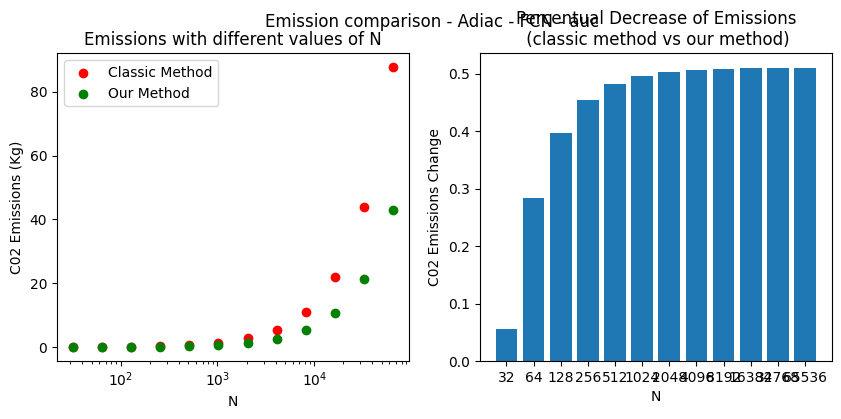

In [189]:
for (dataset, model, metric), group in results_df.groupby(['dataset','model','metric']):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(f"Emission comparison - {dataset} - {model} - {metric}")
    
#     ax1.bar(['User baseline', 'User goal', 'Achieved', 'Error'], group[['base_experiment_metric_result', 'user_goal', 'real_result', 'goal_error']].mean())
    
    ax1.scatter(group['phase_one_hyperparameter_search_iterations'], group['classic_method_emissions_kg'], c='r', label='Classic Method')
    ax1.scatter(group['phase_one_hyperparameter_search_iterations'], group['our_method_emissions_kg'], c='g', label='Our Method')
    ax1.set_xscale('log')
    ax1.set_title('Emissions with different values of N')
    ax1.set_xlabel('N')
    ax1.set_ylabel('C02 Emissions (Kg)')
    ax1.legend()
    
    ax2.bar(np.array(group['phase_one_hyperparameter_search_iterations'], dtype='str'), -group['emissions_percentual_decrease'])
    ax2.set_title('Percentual Decrease of Emissions\n (classic method vs our method)')
    ax2.set_xlabel('N')
    ax2.set_ylabel('C02 Emissions Change')
    
    break

    


## Mathematical Analysis

Classic Method for hyperparameter search
- Using all of the data, test different models, evaluate and finally choose. 
- There are many methods for this
- Training and running 1 model is okay, in this phase more than 1000 runs may be done

Our Method
- Perform Hyperparameter search on a reduced set of the data, as usual
- Report results to our tool
- Perform a final and much shorter run of hyperparameter search on the reported results by our tool


- $N = $ Number of hyperparameter iterations performed on the classic method and first phase of our method
- $n = $ Number of hyperparameter search iterations performed on the second phase of out method
- $e = $ Emissions (Kg) of 1 run (training + testing a model) on 100% of the data available
- $t_i = $ Percent of dataset used for the first phase of our method (choosen by the user)
- $t_f = $ Percent of dataset used for the second phase of our method (reported by the tool)


Classic Method Emissions: $N*e$
Our Method Emissions: $N*e*t_i + n*e*t_f$


Percentual change of our method vs the classic method
$$100*\frac{N*e*t_i + n*e*t_f - N*e}{N*e}$$

With this formula, we can see two things based on the variable $N$:

**Break even point**: How many hyperparameter search iterations must be performed for our method to be more energy efficient than the classic method
$$N = \frac{t_f*n}{1-t_i}$$

To put this number into perspective, if we assume only 10 runs will be done in the second phase of hyperparameter search ($t_f$) in our method, the user used 0.5 of the dataset ($n$) for the initial results, we get the following results based on the tool reported $t_f$


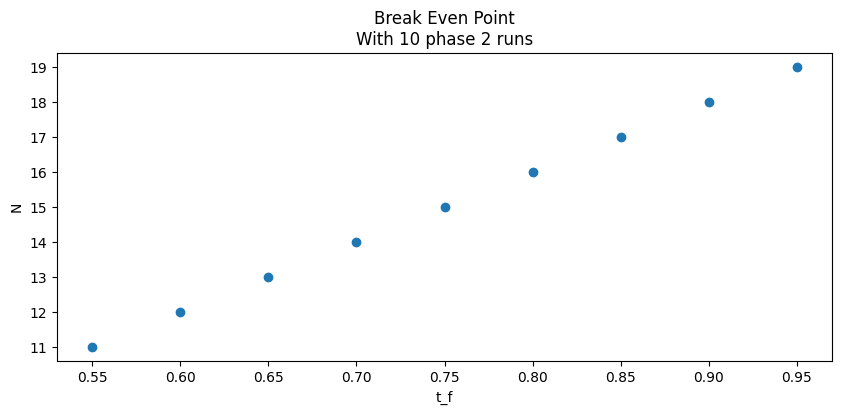

In [11]:
n = 10
t_i = 0.5
t_f = np.linspace(0.55, 0.95, 9)
N = t_f*n/(1-t_i)

plt.scatter(t_f, N)
plt.title(f"Break Even Point\nWith {n} phase 2 runs")
plt.xlabel('t_f')
plt.ylabel('N')
plt.show()

**Percentual Decrease Limit**: After N becomes big enough, the term $n*t_f*e$ (Emissions of the second phase of our method) becomes insignificant and the emissions are dominated by the term $t_i*e*N$. On the limit it can be shown that the percentual decrease reaches the value $t_i - 1$
- If the researcher used 0.4 percent of the dataset for the first part of our method, he would reduce his emissions by 60% by using our method compared to the classic method.


Text(0, 0.5, 'C02 Emissions Change')

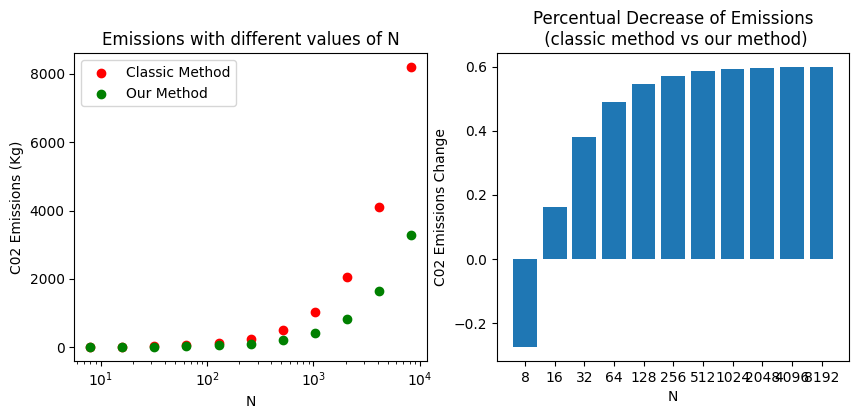

In [12]:
e = 1
t_i = 0.4
N = 2**np.arange(3, 14)

# Irrelevant terms in the limit
n = 10
t_f = 0.7 

classic_method_emissions = N*e
our_method_emissions = N*e*t_i + n*e*t_f
percentual_change = (our_method_emissions - classic_method_emissions)/classic_method_emissions


fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.suptitle(f"Percentual Change Limit")

ax1.scatter(N, classic_method_emissions, c='r', label='Classic Method')
ax1.scatter(N, our_method_emissions, c='g', label='Our Method')
ax1.set_xscale('log')
ax1.set_title('Emissions with different values of N')
ax1.set_xlabel('N')
ax1.set_ylabel('C02 Emissions (Kg)')
ax1.legend()

ax2.bar(np.array(N, dtype='str'), -percentual_change)
ax2.set_title('Percentual Decrease of Emissions\n (classic method vs our method)')
ax2.set_xlabel('N')
ax2.set_ylabel('C02 Emissions Change')
    

## Extra: Relation on amount of data vs emissions

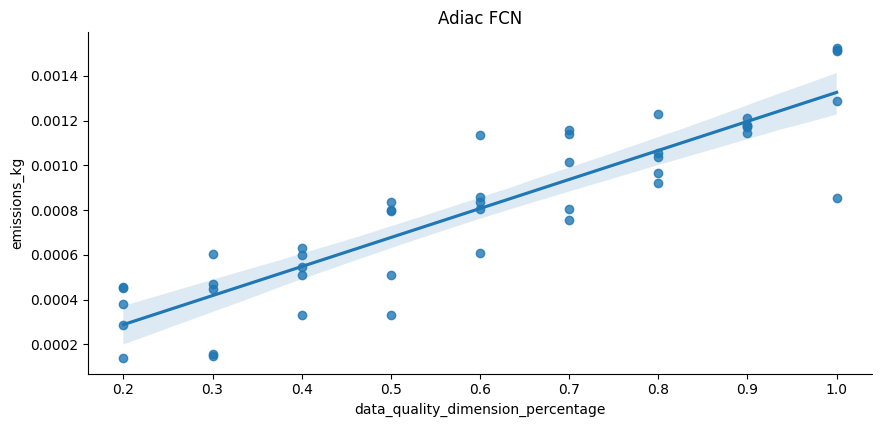

In [190]:
# zero_data_extra = pd.DataFrame([{'data_quality_dimension_percentage': 0, 'emissions_kg': 0} for i in range(100)])

for (dataset, model), group in time_series_runs_df.groupby(['dataset','model']):
#     group = pd.concat((group, zero_data_extra))
    g = sns.lmplot(x='data_quality_dimension_percentage',y='emissions_kg',data=group,fit_reg=True) 
    g.set(title =f"{dataset} {model}")
    g = g.fig.set_size_inches(10, 4)
    
    break
